In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

In [82]:
df = pd.read_csv('DATA.csv', index_col=0)
df['expiration_C']=pd.to_datetime(df['expiration_C'])

In [85]:
nasdaq = pd.read_csv('NASDAQ.csv')
nasdaq['Date']=pd.to_datetime(nasdaq['Date'])

In [142]:
newdf = pd.merge(df, nasdaq, how='left', left_on='expiration_C', right_on='Date')

In [ ]:
# newdf['strike_adj'] = newdf['strike'] / newdf['implied_S_y']

In [145]:
newdf['pnl_long_Call'] =  np.maximum(newdf['Close/Last']-newdf['strike'],0)-newdf['bid_1545_C']
newdf['pnl_long_Put'] =  np.maximum(newdf['strike']-newdf['Close/Last'],0)-newdf['bid_1545_P']
newdf['pnl_short_Call'] = - np.maximum(newdf['Close/Last']-newdf['strike'],0) + newdf['ask_1545_C'] 
newdf['pnl_short_Put'] =  - np.maximum(newdf['strike']-newdf['Close/Last'],0) + newdf['ask_1545_P'] 

In [146]:
newdf[['quote_date', 'Close/Last', 'strike', 'bid_1545_C', 'ask_1545_C','bid_1545_P', 'ask_1545_P', 'pnl_long_Call', 'pnl_long_Put', 'pnl_short_Call', 'pnl_short_Put']].head()

,quote_date,Close/Last,strike,bid_1545_C,ask_1545_C,bid_1545_P,ask_1545_P,pnl_long_Call,pnl_long_Put,pnl_short_Call,pnl_short_Put
0,2018-01-12,6412.68,5400.0,1347.0,1368.3,0.05,3.1,-334.32,-0.05,355.62,3.1
1,2018-01-12,6412.68,5500.0,1248.0,1269.0,0.25,3.7,-335.32,-0.25,356.32,3.7
2,2018-01-12,6412.68,5600.0,1151.6,1165.9,0.65,4.2,-338.92,-0.65,353.22,4.2
3,2018-01-12,6412.68,5700.0,1052.4,1066.7,1.70,4.3,-339.72,-1.70,354.02,4.3
4,2018-01-12,6412.68,5800.0,953.1,967.4,2.40,5.1,-340.42,-2.40,354.72,5.1


In [147]:
# get 28-day vol of NDX 100
vols = []
quote_dates = newdf['quote_date'].unique()
expirations = newdf['expiration_C'].unique()
for i in range(len(quote_dates)):
    q = quote_dates[i]
    e = expirations[i]
    NDX = nasdaq[(nasdaq['Date'] >= q) & (nasdaq['Date'] <= e)]
    vols.append(NDX['Close/Last'].std())

monthly_vol = pd.DataFrame({'quote_date' : quote_dates, 'vol' : vols})
newdf = pd.merge(newdf, monthly_vol, on = 'quote_date', how = 'left')

In [151]:
newdf['vol_adj_strike'] = (newdf['strike']-newdf['implied_S_x']) / newdf['vol']

In [152]:
newdf

,quote_date,expiration_C,strike,option_type_C,bid_1545_C,ask_1545_C,expiration_P,option_type_P,bid_1545_P,ask_1545_P,date,rate,implied_S_x,moneyness,implied_S_y,Date,Close/Last,Open,High,Low,pnl_long_Call,pnl_long_Put,pnl_short_Call,pnl_short_Put,vol,vol_adj_strike
0,2018-01-12,2018-02-09,5400.0,C,1347.00,1368.30,2018-02-09,P,0.05,3.1,2018-01-12,0.0131,6750.221453,1350.221453,6751.233067,2018-02-09,6412.68,6395.16,6453.43,6164.43,-334.32,-0.05,355.62,3.10,199.483861,-6.768575
1,2018-01-12,2018-02-09,5500.0,C,1248.00,1269.00,2018-02-09,P,0.25,3.7,2018-01-12,0.0131,6750.563054,1250.563054,6751.233067,2018-02-09,6412.68,6395.16,6453.43,6164.43,-335.32,-0.25,356.32,3.70,199.483861,-6.268994
2,2018-01-12,2018-02-09,5600.0,C,1151.60,1165.90,2018-02-09,P,0.65,4.2,2018-01-12,0.0131,6750.254655,1150.254655,6751.233067,2018-02-09,6412.68,6395.16,6453.43,6164.43,-338.92,-0.65,353.22,4.20,199.483861,-5.766154
3,2018-01-12,2018-02-09,5700.0,C,1052.40,1066.70,2018-02-09,P,1.70,4.3,2018-01-12,0.0131,6750.371256,1050.371256,6751.233067,2018-02-09,6412.68,6395.16,6453.43,6164.43,-339.72,-1.70,354.02,4.30,199.483861,-5.265445
4,2018-01-12,2018-02-09,5800.0,C,953.10,967.40,2018-02-09,P,2.40,5.1,2018-01-12,0.0131,6750.212857,950.212857,6751.233067,2018-02-09,6412.68,6395.16,6453.43,6164.43,-340.42,-2.40,354.72,5.10,199.483861,-4.763357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10893,2022-11-11,2022-12-09,14600.0,C,0.20,2.60,2022-12-09,P,2740.00,2764.7,2022-11-11,0.0371,11804.796038,-2795.203962,11805.333099,2022-12-09,11563.33,11594.38,11707.09,11550.31,-0.20,296.67,2.60,-271.97,167.500778,16.687707
10894,2022-11-11,2022-12-09,14700.0,C,0.10,2.40,2022-12-09,P,2839.40,2864.2,2022-11-11,0.0371,11804.892928,-2895.107072,11805.333099,2022-12-09,11563.33,11594.38,11707.09,11550.31,-0.10,297.27,2.40,-272.47,167.500778,17.284141
10895,2022-11-11,2022-12-09,14800.0,C,0.05,2.25,2022-12-09,P,2939.00,2963.8,2022-11-11,0.0371,11804.889819,-2995.110181,11805.333099,2022-12-09,11563.33,11594.38,11707.09,11550.31,-0.05,297.67,2.25,-272.87,167.500778,17.881172
10896,2022-11-11,2022-12-09,14900.0,C,0.00,2.10,2022-12-09,P,3038.60,3063.3,2022-11-11,0.0371,11804.936710,-3095.063290,11805.333099,2022-12-09,11563.33,11594.38,11707.09,11550.31,0.00,298.07,2.10,-273.37,167.500778,18.477904


In [292]:
newdf[67:133][['quote_date','vol_adj_strike']]

,quote_date,vol_adj_strike
67,2018-01-12,-0.057117
68,2018-01-12,-0.006181
69,2018-01-12,0.040995
70,2018-01-12,0.091930
71,2018-01-12,0.116270
72,2018-01-12,0.141863
73,2018-01-12,0.192298
74,2018-01-12,0.242983
75,2018-01-12,0.292916
76,2018-01-12,0.342097


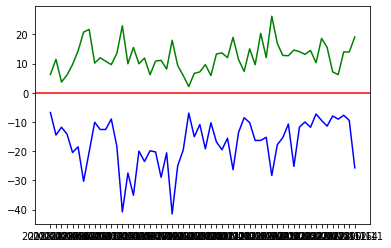

In [156]:
def adj_strike_min(group):
    return group['vol_adj_strike'].min() # smallest adj strike on a given date

def adj_strike_max(group):
    return group['vol_adj_strike'].max() # largest adj strike on a given date

low_bound = newdf.groupby("quote_date").apply(adj_strike_min)
high_bound = newdf.groupby("quote_date").apply(adj_strike_max)

fig, ax1 = plt.subplots()
plt.plot(low_bound, label="Minimum Strike", color='b')
plt.plot(high_bound, label="Maximum Strike", color='g')
plt.axhline(0, label="NDX", color='r')
# ax1.set_xlabel('Quote Date')
# ax1.set_ylabel('Strike Price and NDX', color='k')
# ax1.tick_params(axis='y', labelcolor='k')
# ax1.legend(loc='upper left')
# # Create a secondary y-axis for the bar graph
# ax2 = ax1.twinx()
# # Plot the bar graph on the secondary y-axis
# ax2.bar(newdf.groupby("quote_date").apply(lambda x: x.name), 
#         newdf.groupby("quote_date").apply(group_length), 
#         label="Number of Strikes", color='orange', alpha=0.5, width=20)

# ax2.set_ylabel('Number of Strikes', color='k')
# ax2.tick_params(axis='y', labelcolor='k')
# ax2.legend(loc='upper right')
# plt.title("NDX 100 Strike Price Range 2018 - 2022")
plt.show()

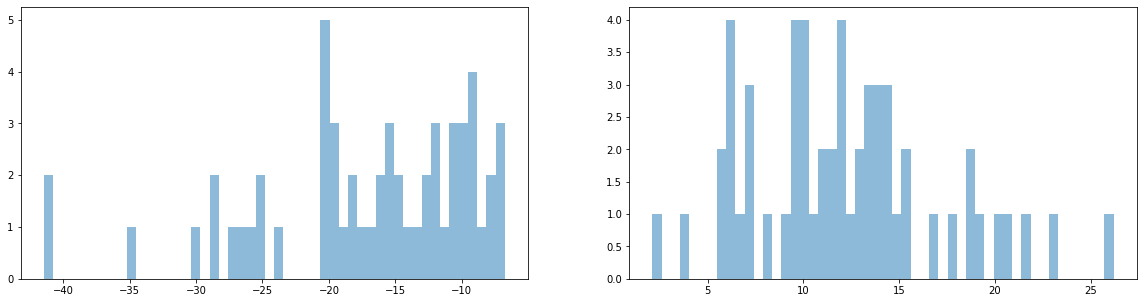

In [160]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
ax[0].hist(low_bound, bins=50, alpha=0.5, label='Minimum Strike')
ax[1].hist(high_bound, bins=50, alpha=0.5, label='Maximum Strike')
plt.show()

In [175]:
high = np.mean(high_bound)
low = np.mean(low_bound)
print(high, low)    

12.218140627510662 -17.166254447209425


In [176]:
# eliminate out of range strikes
newdf = newdf[(newdf['vol_adj_strike'] >= low) & (newdf['vol_adj_strike'] <= high)]

In [182]:
# plt.plot(newdf.groupby("quote_date").size(), color='b')

In [322]:
# number of strikes per day
length = newdf.groupby("quote_date").size().min()

In [264]:
print(newdf[newdf['quote_date'] == '2018-01-12']['vol_adj_strike'].min())
print(newdf[newdf['quote_date'] == '2018-01-12']['vol_adj_strike'].max())
print(len(newdf[newdf['quote_date'] == '2018-01-12']['vol_adj_strike']))

-6.768574908932133
6.255753812805641
118


In [323]:
# strikes intervals

points = np.linspace(low, high, length)

In [324]:
len(points)

66

In [ ]:
# find the nearest strike data


In [325]:
pnl_2 = pd.merge(pd.DataFrame({'quote_date': newdf['quote_date'].unique()}), pd.DataFrame({'no': list(range(1,length+1)),'strike': points}), how='cross')
len(pnl_2)

3696

In [326]:
pnl_2[['vol_adj_strike', 'pnl_long_Call','pnl_long_Put','pnl_short_Call','pnl_short_Put']] = [0,0,0,0,0]

for index, row in pnl_2.iterrows():
    selection = newdf[(newdf['quote_date'] == row['quote_date'])].iloc[(newdf[(newdf['quote_date'] == row['quote_date'])]['vol_adj_strike'] - row['strike']).abs().argsort()[:1]]    
    if abs(selection['vol_adj_strike'].values[0] - row['strike'])<=(high-low)/(length-1):
        pnl_2.at[index, 'vol_adj_strike'] = selection['vol_adj_strike'].values[0]
        pnl_2.at[index, 'pnl_long_Call'] = selection['pnl_long_Call'].values[0]
        pnl_2.at[index, 'pnl_long_Put'] = selection['pnl_long_Put'].values[0]
        pnl_2.at[index, 'pnl_short_Call'] = selection['pnl_short_Call'].values[0]
        pnl_2.at[index, 'pnl_short_Put'] = selection['pnl_short_Put'].values[0]

In [327]:
(high-low)/(length-1)

0.4520676165341552

In [330]:
diff = pnl_2['vol_adj_strike'] - pnl_2['strike']

In [332]:
pnl_2[67:134]

,quote_date,no,strike,vol_adj_strike,pnl_long_Call,pnl_long_Put,pnl_short_Call,pnl_short_Put
67,2018-02-09,2,-16.714187,0.000000,0.00,0.00,0.00,0.00
68,2018-02-09,3,-16.262119,0.000000,0.00,0.00,0.00,0.00
69,2018-02-09,4,-15.810052,0.000000,0.00,0.00,0.00,0.00
70,2018-02-09,5,-15.357984,0.000000,0.00,0.00,0.00,0.00
71,2018-02-09,6,-14.905916,-14.455814,708.08,0.00,-688.08,5.00
72,2018-02-09,7,-14.453849,-14.455814,708.08,0.00,-688.08,5.00
73,2018-02-09,8,-14.001781,-13.854610,707.48,-0.10,-687.58,5.10
74,2018-02-09,9,-13.549714,-13.251596,706.78,-0.60,-686.98,5.60
75,2018-02-09,10,-13.097646,-13.251596,706.78,-0.60,-686.98,5.60
76,2018-02-09,11,-12.645578,-12.648583,706.08,-1.20,-686.18,6.20


In [331]:
diff[67:134]

67     16.714187
68     16.262119
69     15.810052
70     15.357984
71      0.450103
72     -0.001965
73      0.147171
74      0.298117
75     -0.153950
76     -0.003004
77      0.148093
78      0.297983
79     -0.154085
80     -0.003742
81      0.145998
82      0.296642
83     -0.155425
84     -0.004781
85      0.145863
86      0.296206
87     -0.155861
88     -0.005519
89      0.148745
90      0.298787
91     -0.002905
92     -0.003843
93     -0.005083
94     -0.006022
95     -0.006960
96     -0.008200
97     -0.008536
98     -0.008871
99     -0.009206
100    -0.000794
101    -0.000827
102    -0.001766
103    -0.002704
104     0.000580
105    -0.005788
106    -0.006726
107    -0.000426
108     0.011908
109     0.010366
110     0.007919
111     0.006378
112     0.000161
113    -0.000778
114    -0.008503
115    -0.012156
116    -0.014000
117    -0.014938
118    -0.015273
119    -0.015005
120    -0.015039
121     0.136209
122     0.287155
123    -0.164913
124    -0.013967
125     0.1363

In [311]:
call_PNL = pnl_2.pivot(index='quote_date', columns='no', values='pnl_long_Call')
put_PNL = pnl_2.pivot(index='quote_date', columns='no', values='pnl_long_Put')
call_S_PNL = pnl_2.pivot(index='quote_date', columns='no', values='pnl_short_Call')
put_S_PNL = pnl_2.pivot(index='quote_date', columns='no', values='pnl_short_Put') 
call_PNL.columns = [f"{col}_C" for col in call_PNL.columns]
put_PNL.columns = [f"{col}_P" for col in put_PNL.columns]
call_S_PNL.columns = [f"{col}_C_S" for col in call_S_PNL.columns]
put_S_PNL.columns = [f"{col}_P_S" for col in put_S_PNL.columns]
option_PNL = pd.merge(call_PNL , put_PNL, left_on = 'quote_date', right_on = 'quote_date')
option_PNL = pd.merge(option_PNL , call_S_PNL, left_on = 'quote_date', right_on = 'quote_date')
option_PNL = pd.merge(option_PNL , put_S_PNL, left_on = 'quote_date', right_on = 'quote_date')
option_PNL

,1_C,2_C,3_C,4_C,5_C,6_C,7_C,8_C,9_C,10_C,11_C,12_C,13_C,14_C,15_C,16_C,17_C,18_C,19_C,20_C,21_C,22_C,23_C,24_C,25_C,26_C,27_C,28_C,29_C,30_C,31_C,32_C,33_C,34_C,35_C,36_C,37_C,38_C,39_C,40_C,41_C,42_C,43_C,44_C,45_C,46_C,47_C,48_C,49_C,50_C,51_C,52_C,53_C,54_C,55_C,56_C,57_C,58_C,59_C,60_C,61_C,62_C,63_C,64_C,65_C,66_C,1_P,2_P,3_P,4_P,5_P,6_P,7_P,8_P,9_P,10_P,11_P,12_P,13_P,14_P,15_P,16_P,17_P,18_P,19_P,20_P,21_P,22_P,23_P,24_P,25_P,26_P,27_P,28_P,29_P,30_P,31_P,32_P,33_P,34_P,35_P,36_P,37_P,38_P,39_P,40_P,41_P,42_P,43_P,44_P,45_P,46_P,47_P,48_P,49_P,50_P,51_P,52_P,53_P,54_P,55_P,56_P,57_P,58_P,59_P,60_P,61_P,62_P,63_P,64_P,65_P,66_P,1_C_S,2_C_S,3_C_S,4_C_S,5_C_S,6_C_S,7_C_S,8_C_S,9_C_S,10_C_S,11_C_S,12_C_S,13_C_S,14_C_S,15_C_S,16_C_S,17_C_S,18_C_S,19_C_S,20_C_S,21_C_S,22_C_S,23_C_S,24_C_S,25_C_S,26_C_S,27_C_S,28_C_S,29_C_S,30_C_S,31_C_S,32_C_S,33_C_S,34_C_S,35_C_S,36_C_S,37_C_S,38_C_S,39_C_S,40_C_S,41_C_S,42_C_S,43_C_S,44_C_S,45_C_S,46_C_S,47_C_S,48_C_S,49_C_S,50_C_S,51_C_S,52_C_S,53_C_S,54_C_S,55_C_S,56_C_S,57_C_S,58_C_S,59_C_S,60_C_S,61_C_S,62_C_S,63_C_S,64_C_S,65_C_S,66_C_S,1_P_S,2_P_S,3_P_S,4_P_S,5_P_S,6_P_S,7_P_S,8_P_S,9_P_S,10_P_S,11_P_S,12_P_S,13_P_S,14_P_S,15_P_S,16_P_S,17_P_S,18_P_S,19_P_S,20_P_S,21_P_S,22_P_S,23_P_S,24_P_S,25_P_S,26_P_S,27_P_S,28_P_S,29_P_S,30_P_S,31_P_S,32_P_S,33_P_S,34_P_S,35_P_S,36_P_S,37_P_S,38_P_S,39_P_S,40_P_S,41_P_S,42_P_S,43_P_S,44_P_S,45_P_S,46_P_S,47_P_S,48_P_S,49_P_S,50_P_S,51_P_S,52_P_S,53_P_S,54_P_S,55_P_S,56_P_S,57_P_S,58_P_S,59_P_S,60_P_S,61_P_S,62_P_S,63_P_S,64_P_S,65_P_S,66_P_S
quote_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-334.32,-335.32,-338.92,-339.72,-340.42,0.00,-341.82,-343.82,-345.92,-348.52,-352.62,-359.22,-300.60,-220.40,-155.90,-98.10,-54.70,-27.10,-11.00,-4.20,-1.95,-0.25,-0.05,-0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.05,-0.25,-0.65,-1.7,-2.40,0.00,-3.40,-5.10,-6.90,-8.70,-12.30,-16.60,41.92,123.62,189.02,247.42,292.52,322.32,339.32,347.72,350.72,355.42,356.52,356.72,357.32,357.42,0.00,357.72,357.92,358.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,355.62,356.32,353.22,354.02,354.72,0.00,356.12,358.02,360.02,361.32,365.12,368.72,309.40,228.80,163.50,105.00,60.40,30.30,13.90,6.70,4.50,3.60,2.60,2.05,1.70,1.45,0.00,1.25,1.10,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,3.1,3.7,4.20,4.30,5.1,0.00,6.2,7.90,9.70,11.40,15.20,20.40,-38.52,-119.42,-183.32,-241.22,-284.52,-313.42,-329.52,-335.12,-336.62,-334.32,-335.32,-335.42,-336.32,-336.32,0.00,-336.32,-336.52,-336.82,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2018-02-09,0.00,0.00,0.00,0.00,0.00,0.00,708.08,707.48,0.00,706.78,706.08,705.18,0.00,704.08,702.88,701.48,0.00,699.88,697.98,695.78,0.00,692.98,689.98,687.38,0.00,681.38,676.98,671.98,666.08,659.28,651.38,642.28,631.68,619.48,605.08,588.38,568.78,545.78,517.78,486.38,449.28,406.08,356.98,298.38,236.18,169.28,98.83,26.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.10,0.00,-0.60,-1.20,-1.85,0.00,-2.70,-3.70,-4.8,0.00,-6.20,-7.90,-9.90,0.00,-12.30,-15.10,-18.60,0.00,-23.50,-27.4,-31.90,-37.30,-40.60,-48.00,-56.80,-67.10,-79.10,-93.10,-109.60,-128.70,-151.30,-178.20,-208.80,-245

In [355]:
option_PNL.to_csv('option_PNL_1_10.csv')

In [328]:
pip install cvxpy

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Sigma

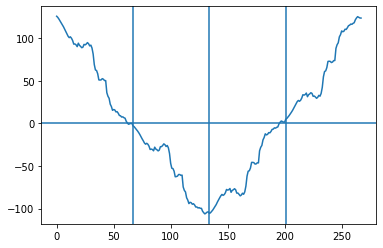

In [32]:
plt.plot(mu)
plt.axvline(x=67)
plt.axvline(x=134)
plt.axvline(x=201)
plt.axhline(y=0)


In [281]:
len(mu)

134

In [267]:
Sigma.shape

(268, 268)

constraint $\gamma$<->$L$:

$w^T w\leq L^2/d \iff L<\frac{\sqrt{d}||\mu||}{\gamma\sigma_\infty}$

find $\sigma_\infty$ and $||\mu||$


In [314]:
n

264

In [17]:
option_PNL = pd.read_csv('option_PNL_1_10.csv', index_col=0)

In [18]:
option_PNL

,1_C,2_C,3_C,4_C,5_C,6_C,7_C,8_C,9_C,10_C,11_C,12_C,13_C,14_C,15_C,16_C,17_C,18_C,19_C,20_C,21_C,22_C,23_C,24_C,25_C,26_C,27_C,28_C,29_C,30_C,31_C,32_C,33_C,34_C,35_C,36_C,37_C,38_C,39_C,40_C,41_C,42_C,43_C,44_C,45_C,46_C,47_C,48_C,49_C,50_C,51_C,52_C,53_C,54_C,55_C,56_C,57_C,58_C,59_C,60_C,61_C,62_C,63_C,64_C,65_C,66_C,1_P,2_P,3_P,4_P,5_P,6_P,7_P,8_P,9_P,10_P,11_P,12_P,13_P,14_P,15_P,16_P,17_P,18_P,19_P,20_P,21_P,22_P,23_P,24_P,25_P,26_P,27_P,28_P,29_P,30_P,31_P,32_P,33_P,34_P,35_P,36_P,37_P,38_P,39_P,40_P,41_P,42_P,43_P,44_P,45_P,46_P,47_P,48_P,49_P,50_P,51_P,52_P,53_P,54_P,55_P,56_P,57_P,58_P,59_P,60_P,61_P,62_P,63_P,64_P,65_P,66_P,1_C_S,2_C_S,3_C_S,4_C_S,5_C_S,6_C_S,7_C_S,8_C_S,9_C_S,10_C_S,11_C_S,12_C_S,13_C_S,14_C_S,15_C_S,16_C_S,17_C_S,18_C_S,19_C_S,20_C_S,21_C_S,22_C_S,23_C_S,24_C_S,25_C_S,26_C_S,27_C_S,28_C_S,29_C_S,30_C_S,31_C_S,32_C_S,33_C_S,34_C_S,35_C_S,36_C_S,37_C_S,38_C_S,39_C_S,40_C_S,41_C_S,42_C_S,43_C_S,44_C_S,45_C_S,46_C_S,47_C_S,48_C_S,49_C_S,50_C_S,51_C_S,52_C_S,53_C_S,54_C_S,55_C_S,56_C_S,57_C_S,58_C_S,59_C_S,60_C_S,61_C_S,62_C_S,63_C_S,64_C_S,65_C_S,66_C_S,1_P_S,2_P_S,3_P_S,4_P_S,5_P_S,6_P_S,7_P_S,8_P_S,9_P_S,10_P_S,11_P_S,12_P_S,13_P_S,14_P_S,15_P_S,16_P_S,17_P_S,18_P_S,19_P_S,20_P_S,21_P_S,22_P_S,23_P_S,24_P_S,25_P_S,26_P_S,27_P_S,28_P_S,29_P_S,30_P_S,31_P_S,32_P_S,33_P_S,34_P_S,35_P_S,36_P_S,37_P_S,38_P_S,39_P_S,40_P_S,41_P_S,42_P_S,43_P_S,44_P_S,45_P_S,46_P_S,47_P_S,48_P_S,49_P_S,50_P_S,51_P_S,52_P_S,53_P_S,54_P_S,55_P_S,56_P_S,57_P_S,58_P_S,59_P_S,60_P_S,61_P_S,62_P_S,63_P_S,64_P_S,65_P_S,66_P_S
quote_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-334.32,-335.32,-338.92,-339.72,-340.42,0.00,-341.82,-343.82,-345.92,-348.52,-352.62,-359.22,-300.60,-220.40,-155.90,-98.10,-54.70,-27.10,-11.00,-4.20,-1.95,-0.25,-0.05,-0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.05,-0.25,-0.65,-1.7,-2.40,0.00,-3.40,-5.10,-6.90,-8.70,-12.30,-16.60,41.92,123.62,189.02,247.42,292.52,322.32,339.32,347.72,350.72,355.42,356.52,356.72,357.32,357.42,0.00,357.72,357.92,358.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,355.62,356.32,353.22,354.02,354.72,0.00,356.12,358.02,360.02,361.32,365.12,368.72,309.40,228.80,163.50,105.00,60.40,30.30,13.90,6.70,4.50,3.60,2.60,2.05,1.70,1.45,0.00,1.25,1.10,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,3.1,3.7,4.20,4.30,5.1,0.00,6.2,7.90,9.70,11.40,15.20,20.40,-38.52,-119.42,-183.32,-241.22,-284.52,-313.42,-329.52,-335.12,-336.62,-334.32,-335.32,-335.42,-336.32,-336.32,0.00,-336.32,-336.52,-336.82,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2018-02-09,0.00,0.00,0.00,0.00,0.00,0.00,708.08,707.48,0.00,706.78,706.08,705.18,0.00,704.08,702.88,701.48,0.00,699.88,697.98,695.78,0.00,692.98,689.98,687.38,0.00,681.38,676.98,671.98,666.08,659.28,651.38,642.28,631.68,619.48,605.08,588.38,568.78,545.78,517.78,486.38,449.28,406.08,356.98,298.38,236.18,169.28,98.83,26.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.10,0.00,-0.60,-1.20,-1.85,0.00,-2.70,-3.70,-4.8,0.00,-6.20,-7.90,-9.90,0.00,-12.30,-15.10,-18.60,0.00,-23.50,-27.4,-31.90,-37.30,-40.60,-48.00,-56.80,-67.10,-79.10,-93.10,-109.60,-128.70,-151.30,-178.20,-208.80,-245

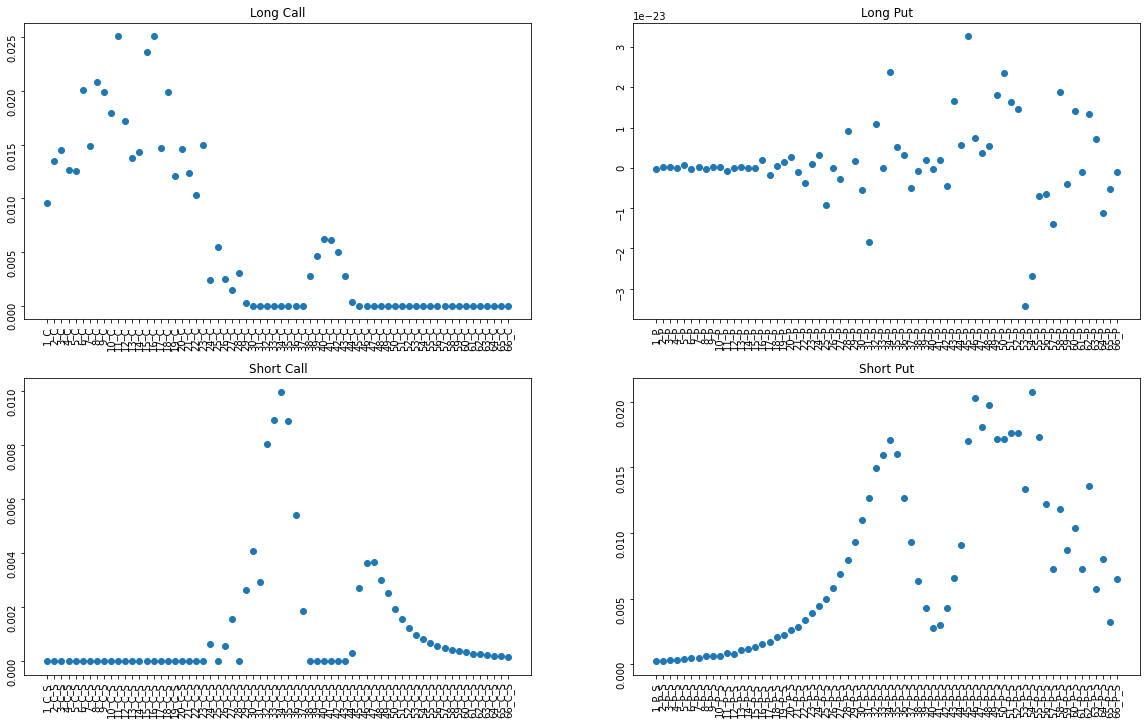

In [20]:
import numpy as np
import cvxpy as cp

# Generate Sigma as a random PSD n*n matrix,  would be substituded by the covariance matrix
# # mu as a random n-vector, would be substituded by the expected return
mu = option_PNL.mean().to_numpy()
n = len(mu)
Sigma = option_PNL.cov()
gamma = 0.0005
lam = 10000000
Sigma_1 = Sigma + lam * np.identity(n)
Sigma_1 = cp.psd_wrap(Sigma_1)
# constraints 
# h=0_n, A=1_n, b=1
# Gw >= h equiv to w_i>=0 for all i
# Aw = b equiv to sum(w_i)=1
h = np.zeros(n)
A = np.ones(n)
b = 1

# Define and solve the CVXPY problem.
w = cp.Variable(n)
prob = cp.Problem(cp.Minimize((1/2) * gamma * cp.quad_form(w, Sigma_1) - mu.T @ w),
            [
                w >= h,
                # A.T @ w == b
                ]
                )
prob.solve(verbose=False)

# # Print result.
# print("\nThe optimal value is", prob.value)
# print("A solution w is")
# print(w.value)

# graph weights vs strike, see if at 1 it is a peak/valley

m = n//4

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12))
ax[0][0].scatter(option_PNL.columns[:m], w.value[:m])
ax[0][0].tick_params(labelrotation=90)
ax[0][0].set_title('Long Call')

ax[0][1].scatter(option_PNL.columns[m:2*m], w.value[m:2*m])
ax[0][1].tick_params(labelrotation=90)
ax[0][1].set_title('Long Put')

ax[1][0].scatter(option_PNL.columns[2*m:3*m], w.value[2*m:3*m])
ax[1][0].tick_params(labelrotation=90)
ax[1][0].set_title('Short Call')

ax[1][1].scatter(option_PNL.columns[3*m:], w.value[3*m:])
ax[1][1].tick_params(labelrotation=90)
ax[1][1].set_title('Short Put')

plt.show()

In [352]:
pip install coptpy

     |████████████████████████████████| 15.0 MB 547 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [12]:
import coptpy 
# Define and solve the CVXPY problem.
w = cp.Variable(n)
prob = cp.Problem(cp.Minimize((1/2) * gamma * cp.quad_form(w, Sigma_1) - mu.T @ w),
            [
                w >= h,
                # A.T @ w == b
                ]
                )
prob.solve(solver =cp.COPT , verbose=True)

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Jan 10 11:18:22 AM: Your problem has 264 variables, 1 constraints, and 0 parameters.
(CVXPY) Jan 10 11:18:22 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 10 11:18:22 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 10 11:18:22 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 10 11:18:22 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 10 11:18:22 AM: Compiling problem (target solver=COPT).
(CV

-51.276371564681696

In [11]:
print(cp.installed_solvers())

['CLARABEL', 'COPT', 'CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIPY', 'SCS']


In [340]:
m

66

In [13]:
w.value[:m]*w.value[2*m:3*m]

array([4.04127976e-15, 4.04316197e-15, 4.07781349e-15, 4.16403156e-15,
       4.19615305e-15, 4.05185461e-15, 4.11631071e-15, 4.06148359e-15,
       4.05819399e-15, 4.04759164e-15, 4.03884157e-15, 4.07998423e-15,
       4.40526256e-15, 4.41748454e-15, 4.08017137e-15, 4.06706737e-15,
       4.51041078e-15, 4.29667400e-15, 4.80138369e-15, 4.64416563e-15,
       4.73601205e-15, 5.20028483e-15, 4.59203924e-15, 1.60615570e-06,
       8.25285372e-15, 1.39961773e-06, 2.36022852e-06, 5.46305465e-13,
       6.28718461e-07, 1.27712927e-14, 4.00949986e-14, 5.59163997e-15,
       5.17582045e-15, 4.83543519e-15, 4.90442271e-15, 5.83721745e-15,
       7.21655753e-14, 8.57626919e-15, 4.93960383e-15, 4.39005604e-15,
       4.32062662e-15, 4.40992033e-15, 5.03099721e-15, 9.73615142e-08,
       4.65896827e-15, 4.30993259e-15, 4.25255089e-15, 4.30633379e-15,
       4.43102066e-15, 4.59323358e-15, 5.04006004e-15, 5.33104675e-15,
       5.58547484e-15, 6.12768699e-15, 6.30980168e-15, 7.14750271e-15,
      

In [14]:
w.value[m:2*m]*w.value[3*m:]

array([5.39368876e-15, 5.54719524e-15, 5.54408288e-15, 5.47511730e-15,
       5.15989722e-15, 5.30737056e-15, 5.25141563e-15, 5.20797620e-15,
       5.01501433e-15, 4.74732753e-15, 5.06054328e-15, 4.61312837e-15,
       4.91365017e-15, 4.76061198e-15, 4.62953656e-15, 4.56522226e-15,
       4.47570015e-15, 4.54852996e-15, 4.43092424e-15, 4.36933226e-15,
       4.28052772e-15, 4.21080324e-15, 4.14305799e-15, 4.12660538e-15,
       4.05996705e-15, 4.01322550e-15, 3.98975452e-15, 3.95495113e-15,
       3.92357877e-15, 3.91533012e-15, 3.88591163e-15, 3.86772872e-15,
       3.86405510e-15, 3.86349411e-15, 3.88853416e-15, 3.96254707e-15,
       4.10425323e-15, 4.37043413e-15, 4.97079404e-15, 7.83125362e-15,
       1.01955978e-14, 7.47496187e-15, 5.98491208e-15, 5.32793592e-15,
       4.45189138e-15, 4.32465143e-15, 4.47368122e-15, 4.40973146e-15,
       4.64607815e-15, 4.59603053e-15, 4.62252005e-15, 4.57765140e-15,
       4.86754741e-15, 4.37236548e-15, 4.49981436e-15, 4.71210171e-15,
      

In [321]:
np.sqrt(w.value.T @ Sigma @ w.value)

260.26117113340024

In [63]:
import numpy as np
import cvxpy as cp

# Generate Sigma as a random PSD n*n matrix,  would be substituded by the covariance matrix
# # mu as a random n-vector, would be substituded by the expected return
for lam in [1000,10000,100000,1000000,10000000]:
  for gamma in [0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]:
    print('\n')
    print(f'lambda = {lam}, gamma = {gamma}')
    mu = pnl_1.mean().to_numpy()
    n = len(mu)
    Sigma = pnl_1.cov()
    # gamma = 1.
    # lam = 500.
    Sigma_1 = Sigma + lam * np.identity(n)
    Sigma_1 = cp.psd_wrap(Sigma_1)
    # constraints 
    # h=0_n, A=1_n, b=1
    # Gw >= h equiv to w_i>=0 for all i
    # Aw = b equiv to sum(w_i)=1
    h = np.zeros(n)
    A = np.ones(n)
    b = 1

    # Define and solve the CVXPY problem.
    w = cp.Variable(n)
    prob = cp.Problem(cp.Minimize((1/2) * gamma * cp.quad_form(w, Sigma_1) - mu.T @ w),
                    [
                        w >= h,
                      A.T @ w == b
                      ]
                      )
    prob.solve()

    print(np.sqrt(w.value.T @ Sigma @ w.value))
    # # Print result.
    # print("\nThe optimal value is", prob.value)
    # print("A solution w is")
    # print(w.value)

    # graph weights vs strike, see if at 1 it is a peak/valley
    
    # fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12))
    # ax[0][0].scatter(pnl_1.columns[:67], w.value[:67])
    # ax[0][0].tick_params(labelrotation=90)

    # ax[0][1].scatter(pnl_1.columns[67:134], w.value[67:134])
    # ax[0][1].tick_params(labelrotation=90)

    # ax[1][0].scatter(pnl_1.columns[134:201], w.value[134:201])
    # ax[1][0].tick_params(labelrotation=90)

    # ax[1][1].scatter(pnl_1.columns[201:], w.value[201:])
    # ax[1][1].tick_params(labelrotation=90)
    # plt.show()



lambda = 1000, gamma = 0.0001
654.5844365966191


lambda = 1000, gamma = 0.001
158.32492184194135


lambda = 1000, gamma = 0.01
30.41228355129159


lambda = 1000, gamma = 0.1
7.428637382764107


lambda = 1000, gamma = 1
1.5371501026023708


lambda = 1000, gamma = 10
0.861162706001084


lambda = 1000, gamma = 100
0.8192633495667592


lambda = 1000, gamma = 1000
0.8155144123076806


lambda = 1000, gamma = 10000
0.8151441656136845


lambda = 1000, gamma = 100000
0.8151071876488772


lambda = 10000, gamma = 0.0001
653.8570257096211


lambda = 10000, gamma = 0.001
160.5704696211674


lambda = 10000, gamma = 0.01
28.706331553750648


lambda = 10000, gamma = 0.1
6.220470871104922


lambda = 10000, gamma = 1
1.5823083652704184


lambda = 10000, gamma = 10
1.2838737712673198


lambda = 10000, gamma = 100
1.2637016482503771


lambda = 10000, gamma = 1000
1.2618020142519857


lambda = 10000, gamma = 10000
1.261613246833843


lambda = 10000, gamma = 100000
1.2615943820713869


lambda = 100000, g

In [ ]:
# Plot trade-off curve.

%config InlineBackend.figure_format = 'svg'

markers_on = [29, 40]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    ax.annotate(r"$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker]+.08, ret_data[marker]-.03))
for i in range(n):
    plt.plot(cp.sqrt(Sigma[i,i]).value, mu[i], 'ro')
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

In [68]:
mu.T@w.value

23.886867947468414

In [67]:
np.sqrt(w.value.T @ Sigma @ w.value)

123.85945986799972

In [20]:
# import numpy as np
# import cvxpy as cp

# # Generate Sigma as a random PSD n*n matrix,  would be substituded by the covariance matrix
# # # mu as a random n-vector, would be substituded by the expected return


# mu = pnl_1.mean().to_numpy()
# n = len(mu)
# Sigma = pnl_1.cov()
# gamma = 1.
# lam = 1.
# Sigma_1 = Sigma + lam * np.identity(n)
# Sigma_1 = cp.psd_wrap(Sigma_1)
# # constraints 
# # h=0_n, A=1_n, b=1
# # Gw >= h equiv to w_i>=0 for all i
# # Aw = b equiv to sum(w_i)=1
# h = np.zeros(n)
# A = np.ones(n)
# b = 1

# # Define and solve the CVXPY problem.
# w = cp.Variable(n)
# prob = cp.Problem(cp.Minimize((mu.T @ w)/ (cp.quad_form(w, Sigma)) - gamma * cp.quad_form(w,np.identity(n))),
#             [
#                 w >= h,
#                 A.T @ w == b
#                 ]
#                 )
# prob.solve()

# # # Print result.
# # print("\nThe optimal value is", prob.value)
# # print("A solution w is")
# # print(w.value)

# # graph weights vs strike, see if at 1 it is a peak/valley

# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12))
# ax[0][0].scatter(pnl_1.columns[:67], w.value[:67])
# ax[0][0].tick_params(labelrotation=90)

# ax[0][1].scatter(pnl_1.columns[67:134], w.value[67:134])
# ax[0][1].tick_params(labelrotation=90)

# ax[1][0].scatter(pnl_1.columns[134:201], w.value[134:201])
# ax[1][0].tick_params(labelrotation=90)

# ax[1][1].scatter(pnl_1.columns[201:], w.value[201:])
# ax[1][1].tick_params(labelrotation=90)
# plt.show()

In [284]:
pnl_1.columns

Index(['1_C', '2_C', '3_C', '4_C', '5_C', '6_C', '7_C', '8_C', '9_C', '10_C',
       ...
       '58_P', '59_P', '60_P', '61_P', '62_P', '63_P', '64_P', '65_P', '66_P', '67_P'], dtype='object', length=134)

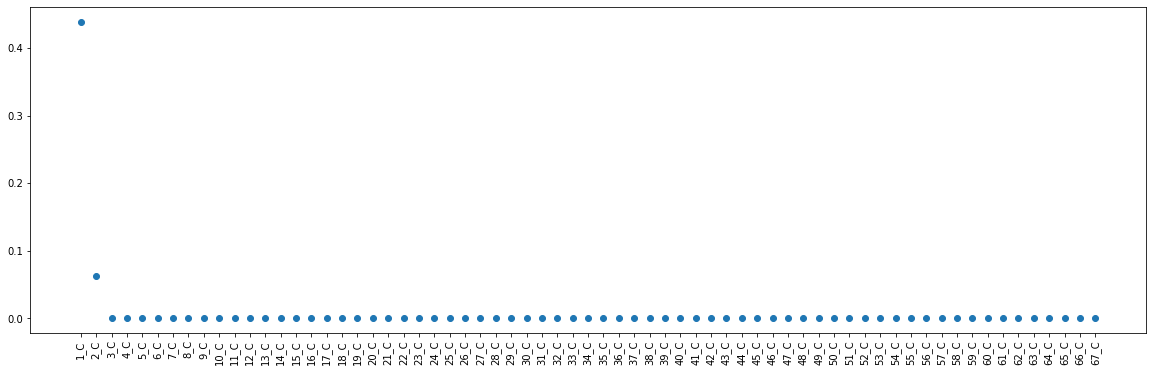

In [293]:
# graph weights vs strike, see if at 1 it is a peak/valley
plt.figure(figsize=(20,6))
plt.scatter(pnl_1.columns[:67], w.value[:67])
plt.xticks(rotation=90)
plt.show()

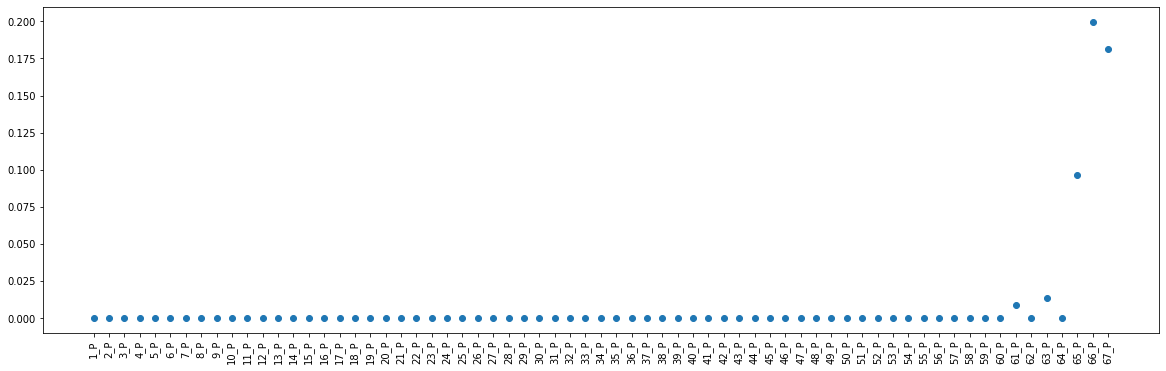

In [289]:
# graph weights vs strike, see if at 1 it is a peak/valley
plt.figure(figsize=(20,6))
plt.scatter(pnl_1.columns[67:], w.value[67:])
plt.xticks(rotation=90)
plt.show()

In [ ]:
# uniformly draw 41 samples of strike_adj from each date
sample_size = 67
newdf_sampled = newdf.groupby('quote_date').apply(lambda x: x.sample(n=sample_size, random_state=42)).reset_index(drop=True)
# rank the strike_adj within each date
newdf_sampled['strike_adj_rank'] = newdf_sampled.groupby('quote_date')['strike_adj'].rank()